## Load MNIST digits dataset

In [1]:
import tensorflow as tf  # Import TensorFlow library

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Output the shapes of training and testing data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

11490434/11490434 [==============================] - 1s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## Building Siamese Neural Network for Image Comparison

In [2]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Reshape, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

# Create input placeholders
input_shape = (28, 28)
img_A_inp = Input(shape=input_shape, name='img_A_inp')
img_B_inp = Input(shape=input_shape, name='img_B_inp')

# Function to create a CNN block
def create_cnn_block(depth):
    model = Sequential()
    model.add(Conv2D(depth, kernel_size=3, strides=1))
    model.add(BatchNormalization())
    model.add(ReLU())
    return model

# Create the shared CNN
cnn = Sequential()
cnn.add(Reshape((28, 28, 1)))

DEPTH = 64
cnn.add(create_cnn_block(DEPTH))
cnn.add(create_cnn_block(DEPTH*2))
cnn.add(create_cnn_block(DEPTH*4))
cnn.add(create_cnn_block(DEPTH*8))
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(64, activation='relu'))

# Apply the shared CNN to both inputs
feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

# Concatenate feature vectors from both images
concat = Concatenate()([feature_vector_A, feature_vector_B])

# Add a Dense layer to perform final classification
dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

# Create the final model
model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

# Print a summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           1586496     ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['sequential[0][0]',         

## Random Sampling & Dimension Confirmation of Training Images and Labels

In [3]:
import numpy as np

# Randomly select 300 indices from the number of training examples
random_indices = np.random.choice(X_train.shape[0], 300, replace=False)

# Use these indices to select a random sample of 300 images and their corresponding labels
X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

# Print the shapes of the sampled images and labels to confirm their dimensions
X_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

## Possible pairs for Siamese network

In [4]:
# Calculate and return the square of the number of training samples 
len(X_train_sample) ** 2


90000

## Generate pairs of images,labels to train Siamese Network

In [5]:
def make_paired_dataset(X, y):
  # Get the total number of samples
  num_samples = len(X)
  
  # Initialize lists for storing pairs of images and their labels
  X_pairs, y_pairs = [], []

  # Loop over all samples
  for i in range(num_samples):
    # For each sample, loop over all other samples to create pairs
    for j in range(num_samples):
      # Append the pair of images and their similarity label 
      #(1 if same class, 0 if different)
      X_pairs.append([X[i], X[j]])
      y_pairs.append(int(y[i] == y[j]))

  # Convert lists of pairs to numpy arrays
  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  # Return paired images and their labels
  return X_pairs, y_pairs

## Function call

In [6]:
make_paired_dataset(X_train_sample, y_train_sample)

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
 
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0

In [7]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

## Random Sampling of Test Images, Labels for Evaluation

In [8]:
# Randomly select 150 indices from the number of test examples
random_indices = np.random.choice(X_test.shape[0], 150, replace=False)

# Use these indices to select a random sample of 150 images and their corresponding labels from the test dataset
X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

# Print the shapes of the sampled test images and labels to confirm their dimensions
X_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [9]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

## Model Compilation

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

## Instantiate the EarlyStopping callback

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# If the model's validation loss doesn't improve for 3 consecutive epochs, 
# the training will be stopped to prevent overfitting
es = EarlyStopping(patience=3)

# Training Siamese model

In [12]:
model.fit(
    # Feed the pairs of training images into the model
    # X_train_pairs[:, 0, :, :] represents the first image in each pair
    # X_train_pairs[:, 1, :, :] represents the second image in each pair
    [X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_split=0.3, 
          epochs=100,
          batch_size=32,
          callbacks=[es])

Epoch 1/100
1969/1969 [==============================] - 70s 30ms/step - loss: 0.2530 - accuracy: 0.9053 - val_loss: 0.1697 - val_accuracy: 0.9293
Epoch 2/100
1969/1969 [==============================] - 58s 30ms/step - loss: 0.0881 - accuracy: 0.9629 - val_loss: 0.0976 - val_accuracy: 0.9660
Epoch 3/100
1969/1969 [==============================] - 55s 28ms/step - loss: 0.0225 - accuracy: 0.9927 - val_loss: 0.0103 - val_accuracy: 0.9977
Epoch 4/100
1969/1969 [==============================] - 58s 29ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0254 - val_accuracy: 0.9906
Epoch 5/100
1969/1969 [==============================] - 58s 29ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 6/100
1969/1969 [==============================] - 55s 28ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0027 - val_accuracy: 0.9993
Epoch 7/100
1969/1969 [==============================] - 58s 29ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0

## Testing Model's Efficacy

In [13]:
# Select the first and eighteenth image from the test dataset
img_A, img_B = X_test[0], X_test[17]

# Get the corresponding labels of the selected images
label_A, label_B = y_test[0], y_test[17]

# Print the labels of the selected images
label_A, label_B

(7, 7)

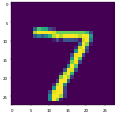

In [14]:
import matplotlib.pyplot as plt

# Create new figure with set DPI=28, as MNIST image =(28,28)
plt.figure(dpi=28)

# Display img_A
plt.imshow(img_A)

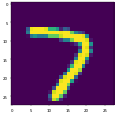

In [15]:
plt.figure(dpi=28)

# Display img_B
plt.imshow(img_B)

## Comparing Images with Siamese Neural Network: Binary Classification

In [16]:
# Predict if img_A and img_B are from the same class (True if prediction > 0.5)
model.predict([img_A.reshape((1, 28, 28)), 
               img_B.reshape((1, 28, 28))]).flatten()[0] > 0.5

1/1 [==============================] - 0s 371ms/step


True

As predicted value is greater than 0.5, the output is True, indicating the model believes the images are of the same class